This is going to randomly sample, but then also return consective data points. both based on a dim

In [1]:
import torch
from torch.utils.data import Dataset, Sampler, DataLoader
import numpy as np
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class WaveformDataset(Dataset):
    def __init__(self, wav_data, t_input):
        self.wav_data = wav_data
        self.time_steps = t_input
        self.length = len(wav_data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.wav_data[idx], self.time_steps[idx]

In [3]:
class RandomConsecutiveSampler(Sampler):
    def __init__(self, data_source, batch_size, consecutive_size):
        self.data_source = data_source
        self.batch_size = batch_size
        self.consecutive_size = consecutive_size

    def __iter__(self):
        indices = np.random.permutation(len(self.data_source) - self.consecutive_size + 1)
        for i in range(0, len(indices), self.batch_size):
            batch_indices = []
            for j in range(i, min(i + self.batch_size, len(indices))):
                start_idx = indices[j]
                batch_indices.extend(range(start_idx, start_idx + self.consecutive_size))
            yield batch_indices

    def __len__(self):
        return (len(self.data_source) - self.consecutive_size ) // self.batch_size


    
    

wav_data = np.linspace(1,100,100).tolist()  # Example waveform data
t_input = np.linspace(1,100,100).tolist()  # Example time step data

dataset = WaveformDataset(wav_data, t_input)
batch_size = 17
consecutive_size = 13

sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)
data_loader = DataLoader(dataset, batch_sampler=sampler)



In [4]:
def consecutive_dif(prediction, target, consecutive_size):
    """
    This will calculate the differences across consecutive points.  
    use RandomConsecutiveSampler for intended results
    """
    pred_reshape = prediction.view(-1,consecutive_size)
    target_reshape = target.view(-1,consecutive_size)
    pred_dif = pred_reshape[:,1:] - pred_reshape[:,:-1]
    target_dif = target_reshape[:,1:] - target_reshape[:,:-1]
    return torch.mean((pred_dif - target_dif)**2)

    
class ConsecutiveDifferenceLoss(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveDifferenceLoss, self).__init__()
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        return torch.mean((pred_dif - target_dif) ** 2)

    
#variations.  you can do the differences with all the other consecutive points.  
# you could do differences along the batch.  those are consecutive points but they shift one each time
# weight those with the dif in t.  that could be interesting.  
#might add in another dataloader? a completely random one? what if you use mse on the random one? 
#thats interesting.  or maybe just weird.  
#no its interesting.  you learn the slopes from differences, then the vertical shift from mse on different points.  
# try these on a single wave to learn frequency.  then add in phi?


In [5]:
# Iterate through the data loader
for batch in data_loader:
    waveforms, time_steps = batch
    print(waveforms.shape,time_steps.shape )
    x = consecutive_dif(waveforms,waveforms+torch.rand_like(waveforms),consecutive_size)
    print(x)
    break

torch.Size([221]) torch.Size([221])
tensor(0.1897, dtype=torch.float64)


In [6]:
#for tomorrow, i want to make the layer that duplicates the input t, 
#and applies different A and phi, then sums them to make one output t. 
#so your first layers have lots and lots, and subsequent layers have few.  
#that is going to be a tree.  i want to specify num branches and num layers.  

#later we try it with triangle waves


In [7]:


class SinCondense(nn.Module):
    def __init__(self, input_dim, add_dim):
        super(SinCondense, self).__init__()
        assert input_dim % add_dim == 0, "input_dim must be divisible by add_dim"
        self.input_dim = input_dim
        self.add_dim = add_dim
        self.a = nn.Parameter(torch.randn(input_dim))
        self.phi = nn.Parameter(torch.randn(input_dim))

    def forward(self, t):
        t_phi = t + self.phi
        sin_t_phi = torch.sin(t_phi)
        output = self.a * sin_t_phi
        output = output.view(-1, self.input_dim // self.add_dim, self.add_dim)
        output = output.sum(dim=-1)
        return output
    def count_params(self):
        return(self.a.shape[0] + self.phi.shape[0])


In [32]:

class SinChain(nn.Module):
    def __init__(self, param_dim):
        super(SinChain, self).__init__()
        self.param_dim = param_dim
        self.a = nn.Parameter(torch.randn(param_dim))
        self.phi = nn.Parameter(torch.randn(param_dim))
        
        self.out_a = nn.Parameter(torch.randn(1))
        self.out_phi = nn.Parameter(torch.randn(1))
    def forward(self, t, learned_t):
        
        phi_t = t.unsqueeze(-1) + self.phi # Broadcasting phi (param_dim, 1) to (batch_size, param_dim)
        a_sin_phi_t = self.a * torch.sin(phi_t) #this should be mat mul really
        out_t = a_sin_phi_t.sum(axis = -1) + learned_t
        return self.out_a * torch.sin(out_t + self.out_phi)
    
    def count_params(self):
        return(self.param_dim * 2 + 2)

In [46]:
class SinCondenseNetwork(nn.Module):
    def __init__(self, add_dim, depth):
        super(SinCondenseNetwork, self).__init__()
        layers = []
        input_dims = sorted([add_dim ** (i+1) for i in range(depth)],reverse=True)
        self.input_shape = add_dim ** depth
        for input_dim in input_dims:
            layers.append(SinCondense(input_dim, add_dim))
           
            
        # Store the layers as a ModuleList
        self.layers = nn.ModuleList(layers)
        
    def forward(self, t):
        t = t.unsqueeze(-1).expand(-1,self.input_shape)
        for layer in self.layers:
            t = layer(t)
        return t
    def count_params(self):
        layer_count = 0
        for i in self.layers:
            layer_count += i.count_params()
        return layer_count
# Example usage
input_dim = 16
add_dim = 2
depth = 3
num_branches = 2

In [80]:
class SinCondenseWithFinalNetwork(nn.Module):
    def __init__(self, add_dim, depth):
        super(SinCondenseWithFinalNetwork, self).__init__()
        layers = []
        input_dims = sorted([add_dim ** (i+1) for i in range(depth)],reverse=True)
        self.input_shape = add_dim ** depth
        self.final_a = torch.tensor([200]) #nn.Parameter(torch.ones(1)*200) #nn.Parameter(torch.randn(1))
        self.final_phi = nn.Parameter(torch.zeros(1)) #nn.Parameter(torch.randn(1))
        
        for input_dim in input_dims:
            layers.append(SinCondense(input_dim, add_dim))
           
            
        # Store the layers as a ModuleList
        self.layers = nn.ModuleList(layers)
        
    def forward(self, t):
        t = t.unsqueeze(-1).expand(-1,self.input_shape)
        for layer in self.layers:
            t = layer(t)
        return self.final_a * (torch.sin(t + self.final_phi))
    def count_params(self):
        layer_count = 0
        for i in self.layers:
            layer_count += i.count_params()
        return layer_count + 2

In [10]:
class SinChainNetwork(nn.Module):
    def __init__(self, param_dim, num_layers):
        super(SinChainNetwork, self).__init__()
        self.layers = nn.ModuleList([SinChain(param_dim) for _ in range(num_layers)])

    def forward(self, t):
        learned_t = torch.zeros_like(t)  # Initialize learned_t with zeros, same shape as t
        for layer in self.layers:
            learned_t = layer(t, learned_t)  # Pass the output as learned_t to the next layer
        return learned_t.unsqueeze(-1)
    
    def count_params(self):
        layer_count = 0
        for i in self.layers:
            layer_count += i.count_params()
        return layer_count 

In [52]:
import torch
import torch.nn as nn

class FourierLayer(nn.Module):
    def __init__(self, param_dim):
        super(FourierLayer, self).__init__()
       
        self.amplitude = nn.Parameter(torch.randn(param_dim))  # Amplitude of each wave
        self.phi = nn.Parameter(torch.randn(param_dim))        # Phase shift of each wave
        self.coefficient = nn.Parameter(torch.randn(param_dim))  # Coefficient for each wave

    def forward(self, t):
        # Broadcast t to have the same shape as param_dim
        t_broadcasted = t.unsqueeze(-1)  # Shape (batch_size, 1) -> (batch_size, 1, param_dim)
        
        # Apply the Fourier transformation: coefficient * sin(coefficient * t + phi)
        wave = self.coefficient * torch.sin(self.coefficient * t_broadcasted + self.phi)
        
        # Multiply by amplitude
        wave_amplified = self.amplitude * wave
        
        # Sum across the param_dim dimension and return
        output = wave_amplified.sum(axis=-1)
        
        return output.unsqueeze(-1)


In [53]:

model = FourierLayer(param_dim = 100)

In [41]:
model = SinChainNetwork(param_dim = 5, num_layers = 340)
model.count_params()

4080

In [68]:
model = SinCondenseNetwork(add_dim = 2,depth = 10)
model.count_params()

4092

In [81]:
model = SinCondenseWithFinalNetwork(add_dim = 2,depth = 10)
model.count_params()

4094

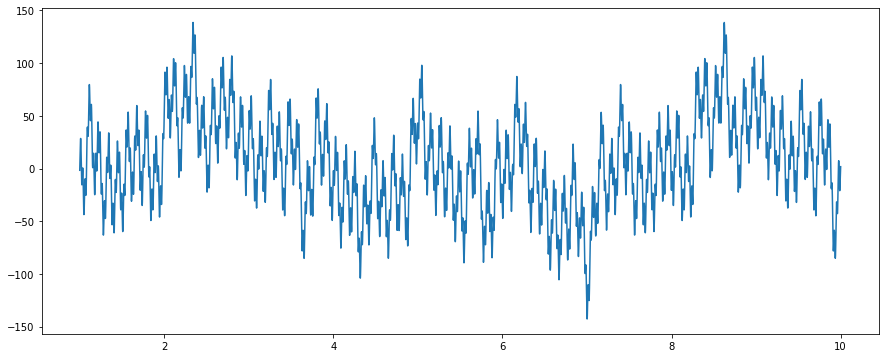

In [12]:

data_t = torch.from_numpy(np.linspace(1,10,10_000))

data =  (16*torch.sin(2*data_t+3)  
    + 2*torch.sin(6*data_t+1.93)  
    + 12*torch.sin(26*data_t+4.2) 
    + 16*torch.sin(21*data_t+2.43)  
    + 33*torch.sin(56*data_t+1.9)  
    + 11*torch.sin(17*data_t+24) 
    + 7.5*torch.sin(2*data_t+3)  
    + 9.4*torch.sin(6*data_t+1.93)  
    + 15.7*torch.sin(246*data_t+4.2) 
    + 17.5*torch.sin(11*data_t+2.43)  
    + 18*torch.sin(5*data_t+1.9)  
    + 25.8*torch.sin(1*data_t+24) )
data = data.detach().numpy().astype(np.float64)
plt.figure(figsize=(15, 6))

plt.plot(data_t, data, label='Layer Output')

In [69]:
dataset = WaveformDataset(data, data_t)
batch_size = 100
consecutive_size = 10

sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)
data_loader = DataLoader(dataset, batch_sampler=sampler)

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming you have defined your model, loss function, and optimizer
# Example:
# model = YourModel()
cdif_loss = ConsecutiveDifferenceLoss(consecutive_size)  # consecutive_dif(prediction, target, consecutive_size)
mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.09)

# Training loop
num_epochs = 20  # Set the number of epochs
model.train()  # Set the model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, ( targets,inputs) in enumerate(data_loader):
        # Move data to the appropriate device (GPU/CPU)
        #inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        mse = mse_loss(outputs, targets.unsqueeze(-1))
        cdif = cdif_loss(outputs, targets)
        loss = cdif + mse

        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    if epoch % 5 == 4:  # Print every 10 mini-batches
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / 10:.4f}')
        running_loss = 0.0

print('Training finished.')


Epoch [5/20], Loss: 17872.1145
Epoch [10/20], Loss: 18648.8624
Epoch [15/20], Loss: 17845.9628
Epoch [20/20], Loss: 17444.3032
Training finished.


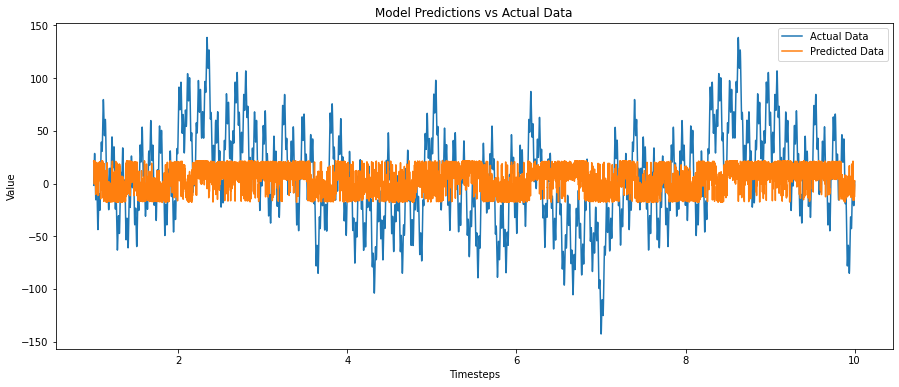

In [71]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Assuming data contains the targets and data_t contains the input timesteps
data_loader_eval = DataLoader(WaveformDataset(data, data_t), batch_size=50, shuffle=False)

with torch.no_grad():
    predictions = []
    actuals = []
    timesteps = []
    for  batch_data,batch_t in data_loader_eval:
        #batch_t, batch_data = batch_t.to(device), batch_data.to(device)
        outputs = model(batch_t)
        predictions.append(outputs.cpu().numpy())
        actuals.append(batch_data.cpu().numpy())
        timesteps.append(batch_t.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)
timesteps = np.concatenate(timesteps, axis=0)

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot( timesteps.flatten(),actuals.flatten(), label='Actual Data')
plt.plot( timesteps.flatten(),predictions.flatten(), label='Predicted Data')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.title('Model Predictions vs Actual Data')
plt.show()
